## Tutorial - Comparing explanation methods

This tutorial demonstrates how to use the library to compare different explanations method with several different evaluation criteria. We use a VGG-16 model and (easily created) toy-dataset Voronoy dataset to showcase the library's functionality.



In [1]:
# Mount Google Drive. #remove
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
#!pip install captum opencv-python torch==1.8.0 torchvision==0.9.0
#!pip install captum opencv-python torch torchvision #torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install captum opencv-python torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import cv2
import glob
import pathlib
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
Looking in links: https://download.pytorch.org/whl/torch_stable.html


### Load Voronoy toy dataset.


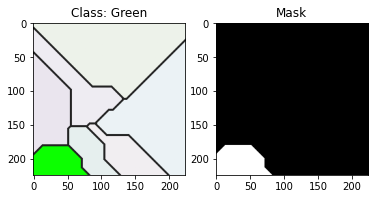

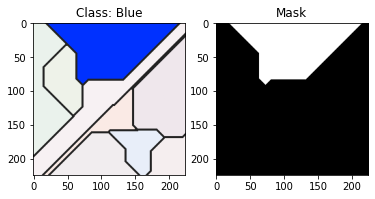

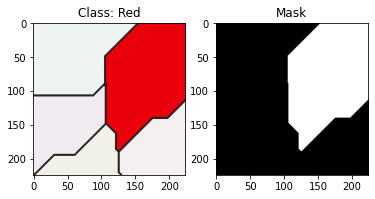

In [2]:
# Load images, labels and masks of Voronoy toy dataset.
test_images = torch.load("/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/test_images_voronoy")
test_masks = torch.load("/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/test_masks_voronoy")
test_labels = torch.load("/content/drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/test_labels_voronoy")
class_labels = {0: "Red", 1: "Green", 2: "Blue"}

def plot_example(index):
    plt.subplot(1, 2, 1)
    plt.imshow(np.moveaxis(test_images[index].numpy(), 0, -1))
    plt.title(f"Class: {class_labels[test_labels[index].item()]}")
    plt.subplot(1, 2, 2)
    plt.imshow(np.moveaxis(test_masks[index].numpy(), 0, -1))
    plt.title(f"Mask")
    plt.show()

# Plot!
[plot_example(index=i)for i in [0, 4, 5]];

### Load a VGG16 model.

(or any other model of choice). 

In [3]:
# Load architecture and weights.
model = torchvision.models.vgg16(pretrained=True)
model.classifier[6] = torch.nn.Linear(4096, 3)
model.load_state_dict(torch.load("drive/MyDrive/Projects/xai_quantification_toolbox/quantus/assets/voronoy_vgg16"))

<All keys matched successfully>

In [4]:
def evaluate_model(model, images, labels, device):
    """Evaluate the accuracy of a torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        logits = torch.cat([logits, model(images)])
        targets = torch.cat([targets, labels])
    
    return torch.nn.functional.softmax(logits, dim=1), targets

# Evaluate model performance.
y_pred, y_true = evaluate_model(model.to(device), test_images.to(device), test_labels.to(device), device)
test_acc = np.mean(np.argmax(y_pred.cpu().numpy(), axis=1) == y_true.cpu().numpy())
print(f"Model test accuracy: {(100 * test_acc):.2f}%")

Model test accuracy: 100.00%


### Load gradient-based attributions.


There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `captum`'s functionality however use whatever approach or library you'd like to create your explanations e.g., `quantus.explain`.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [5]:
# Load a batch of inputs and outputs to use for evaluation.
samples = 10
x_batch, y_batch, s_batch = test_images[0:samples].to(device), test_labels[0:samples].to(device), test_masks[0:samples].to(device)

# Generate attribution-based explanations of the first batch of the test set, including a control variant.
a_batch_g = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
a_batch_ig = IntegratedGradients(model).attribute(inputs=x_batch, 
                                                  target=y_batch, 
                                                  baselines=torch.zeros_like(x_batch), 
                                                  n_steps=10, 
                                                  method="riemann_trapezoid").sum(axis=1).cpu().numpy()
a_batch_convar = torch.reshape(input=torch.Tensor(np.clip(scipy.ndimage.sobel(x_batch), 0,  1).mean(axis=1)), shape=(samples, 224, 224))

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch_g, a_batch_ig]]

Visulize attributions given model and input-output *pairs*.

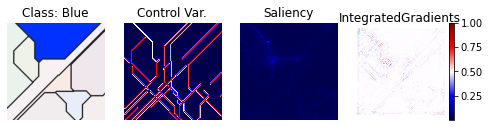

In [26]:
index = 4

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 5))

# Plot!
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
a2 = axes[1].imshow(quantus.normalize_heatmap(a_batch_convar[index]), cmap="seismic") 
a1 = axes[2].imshow(quantus.normalize_heatmap(a_batch_g[index]), cmap="seismic") 
a2 = axes[3].imshow(quantus.normalize_heatmap(a_batch_ig[index]), cmap="seismic") 

# Set titles.
axes[0].title.set_text(f"Class: {class_labels[test_labels[index].item()]}")
axes[1].title.set_text(f"Control Var.")
axes[2].title.set_text(f"Saliency")
axes[3].title.set_text(f"IntegratedGradients")

# Make colorbars.
fig.colorbar(a1, fraction=0.05, pad=0.05, orientation="vertical")

# Other configs.
axes[0].axis("off") 
axes[1].axis("off")
axes[2].axis("off")
axes[3].axis("off")
plt.show()

### Compare gradient-based explanation methods.

In [42]:
# Specify XAI methods, either as a list (str) or as a dictionary with names of explantion methods(str) and either their pre-computed attributions (np.ndarray) or a explanation_func (callable).
explanation_methods = {"Saliency": a_batch_g,
                       "IntegratedGradients": a_batch_ig,
                       "Control Var.": a_batch_convar}

# Specify metrics and set (sensible) hyperparameters.
evaluation_metrics = {"Faithfulness correlation": quantus.FaithfulnessCorrelation(**{"subset_size": 32}),
                      "max-Sensitivity": quantus.MaxSensitivity(),
                      #"Infidelity": quantus.Infidelity(**{"perturb_patch_sizes": list(np.arange(2, 8)),"img_size": 32, "nr_channels": 3})
                      "PointingGame": quantus.PointingGame(),}
                      
 
# Evaluate explanations!
results = quantus.evaluate(evaluation_metrics=evaluation_metrics, 
                           explanation_methods=explanation_methods,
                           model=model.cpu(),
                           x_batch=x_batch,
                           y_batch=y_batch,
                           s_batch=s_batch,
                           agg_func=np.mean,
                           **{"device": device})

# Summarise in a dataframe.      
df = pd.DataFrame(results)
df

TypeError: ignored